In [3]:
%matplotlib inline
import collections
import dask
import gcsfs
import h5py
import io
import matplotlib.pyplot as plt
import numba
import numpy as np
import os
import os.path
import pickle
import requests

from dask.distributed import Client
from dask_kubernetes import KubeCluster
from numba.typed import Dict

In [13]:
cluster.close()

distributed.scheduler - INFO - Scheduler closing...
distributed.scheduler - INFO - Scheduler closing all comms


In [117]:
cluster = KubeCluster.from_yaml('worker-spec.yml')
cluster

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:   tcp://10.36.0.122:45021
distributed.scheduler - INFO -   dashboard at:                     :8787


In [118]:
client = Client(cluster)

distributed.scheduler - INFO - Receive client connection: Client-8c6b8980-483f-11ea-80a1-6a27fb10bcc3
distributed.core - INFO - Starting established connection


Check that the client is working well.

In [119]:
@dask.delayed
def the_sum(a, b):
    return a + b
the_sum(the_sum(1, 2), 3).compute()

distributed.scheduler - INFO - Register tcp://10.36.58.2:38713
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.36.58.2:38713
distributed.core - INFO - Starting established connection


6

distributed.scheduler - INFO - Retire worker names (0,)
distributed.deploy.adaptive - INFO - Retiring workers [0]
distributed.scheduler - INFO - Remove worker tcp://10.36.58.2:38713
distributed.core - INFO - Removing comms to tcp://10.36.58.2:38713
distributed.scheduler - INFO - Lost all workers


In [ ]:
if not os.path.exists('../../.gcs_tokens'):
    # Get a token
    gcsfs.GCSFileSystem(project='neuron-jungle', token='browser')

In [4]:
with open('../.gcs_tokens', 'rb') as f:
    credentials = pickle.load(f)
credentials = credentials[list(credentials.keys())[0]]
fs = gcsfs.GCSFileSystem(project='neuron-jungle', token=credentials)
fs.ls('l4dense/segmentation-volume')[:10]

['l4dense/segmentation-volume/x0y0z3.hdf5',
 'l4dense/segmentation-volume/test',
 'l4dense/segmentation-volume/x3y0z0.hdf5',
 'l4dense/segmentation-volume/x5y5z2.hdf5',
 'l4dense/segmentation-volume/x4y2z1.hdf5',
 'l4dense/segmentation-volume/x5y8z3.hdf5',
 'l4dense/segmentation-volume/x1y8z0.hdf5',
 'l4dense/segmentation-volume/x3y6z0.hdf5',
 'l4dense/segmentation-volume/x2y2z0.hdf5',
 'l4dense/segmentation-volume/x5y0z2.hdf5']

# Create a map from segment id to neuron id

In [17]:
def download(filename):
    url = f"https://l4dense2019.brain.mpg.de/webdav/{filename}"
    result = requests.get(url, verify=False)
    result.raise_for_status()
    return result.content

def upload(filename, data, credentials):
    fs = gcsfs.GCSFileSystem(project='neuron-jungle', token=credentials)
    with fs.open(f'l4dense/{filename}', 'wb') as f:
        num_bytes = f.write(data)
    return num_bytes

def mirror(filename):
    print(f"Fetching {filename}")
    data = download(filename)
    num_bytes = upload(filename, data, credentials)
    return num_bytes


def locally_cache(filename, credentials):
    fs = gcsfs.GCSFileSystem(project='neuron-jungle', token=credentials)
    with fs.open(f'l4dense/{filename}', 'rb') as f:
        data = f.read()
    with open(f'../cache/{filename}', 'wb') as f:
        f.write(data)
    return len(data)

#mirror('axons.hdf5')
#locally_cache('dendrites.hdf5', credentials)
#locally_cache('axons.hdf5', credentials)
locally_cache('segments.hdf5', credentials)

240492120

In [229]:
dendrites['dendrites'].keys()

<KeysViewHDF5 ['agglomerate', 'class', 'neuronId', 'skeleton']>

In [11]:
def get_neuron_map(dendrites):
    # Build a map from agglomerate ID to neuron id
    # First for dendrites
    agg_ids = list(dendrites['dendrites']['agglomerate'])
    neuron_ids = list(dendrites['dendrites']['neuronId'])
    agg_to_neuron_id = {k: neuron_ids[int(k) - 1] for k in agg_ids}

    neuron_segments = collections.defaultdict(lambda: [])
    for agg in list(dendrites['dendrites']['agglomerate'].keys()):
        if agg in agg_to_neuron_id and agg_to_neuron_id[agg] > 0:
            neuron_id = agg_to_neuron_id[agg]
            neuron_segments[neuron_id] += list(dendrites['dendrites']['agglomerate'][agg])

    # Add the axons, if available.
    dendrites_classes = np.array(dendrites['dendrites']['class'])

    neuron_map = {}
    for neuron_id, segment_ids in neuron_segments.items():
        for segment_id in segment_ids:
            neuron_map[segment_id] = neuron_id
    return neuron_segments, neuron_map

In [4]:
def get_neuron_map_with_axons(dendrites, axons):
    neurons = 0
    neurons_with_ais = 0
    neurons_with_axons = 0
    
    agg_ids = list(dendrites['dendrites']['agglomerate'])
    neuron_ids = list(dendrites['dendrites']['neuronId'])
    agg_to_neuron_id = {k: neuron_ids[int(k) - 1] for k in agg_ids}

    neuron_segments = collections.defaultdict(lambda: [])
    dendrite_classes = np.array(dendrites['dendrites']['class'])
    
    unique_neuron_ids = np.unique(neuron_ids)
    assert unique_neuron_ids[0] == 0
    unique_neuron_ids = unique_neuron_ids[1:]
    
    for neuron_id in unique_neuron_ids:
        print(f"Neuron {neuron_id}")
        neurons += 1
        
        # Find the AIS for this "dendrite"
        ais_agg = [k for k, v in agg_to_neuron_id.items() if v == neuron_id and dendrite_classes[int(k) - 1] == 2]

        if ais_agg:
            assert len(ais_agg) == 1
            neurons_with_ais += 1
            ais_segments = np.array(dendrites['dendrites']['skeleton'][ais_agg[0]]['segIds'])
            ais_segments = np.unique(ais_segments[ais_segments > 0])

            # Find an axon whose segments overlap this AIS.
            found_agg = False
            for i, agglomerate in enumerate(axons['axons']['skeleton'].keys()):
                probe = np.unique(np.array(axons['axons']['skeleton'][agglomerate]['segIds']))
                if len(ais_segments) + len(probe) > len(np.unique(np.concatenate((ais_segments, probe)))):
                    print("Found axon")
                    print(len(list(axons['axons']['agglomerate'][agglomerate])))
                    neurons_with_axons += 1
                    found_agg = True
                    neuron_segments[neuron_id] += list(axons['axons']['agglomerate'][agglomerate])
    neuron_map_with_axons = {}
    for neuron_id, segment_ids in neuron_segments.items():
        for segment_id in segment_ids:
            neuron_map_with_axons[segment_id] = neuron_id
    return neuron_segments, neuron_map_with_axons

axon_segments, axon_map = get_neuron_map_with_axons(dendrites, axons)

Neuron 1
Found axon
367
Neuron 2
Neuron 3
Found axon
1
Neuron 4
Found axon
57
Neuron 5
Neuron 6
Neuron 7
Found axon
547
Neuron 8
Found axon
36
Neuron 9
Neuron 10
Found axon
74
Neuron 11
Neuron 12
Neuron 13
Found axon
27
Neuron 14
Found axon
61
Neuron 15
Neuron 16
Neuron 17
Neuron 18
Neuron 19
Found axon
72
Neuron 20
Found axon
153
Neuron 21
Found axon
696
Neuron 22
Found axon
1727
Neuron 23
Neuron 24
Neuron 25
Found axon
797
Neuron 26
Neuron 27
Found axon
153


KeyboardInterrupt: 

In [6]:
def get_neuron_map_with_axons_unrestricted(dendrites, axons):
    neurons = 0
    neurons_with_ais = 0
    neurons_with_axons = 0
    
    agg_ids = list(dendrites['dendrites']['agglomerate'])
    neuron_ids = list(dendrites['dendrites']['neuronId'])
    agg_to_neuron_id = {k: neuron_ids[int(k) - 1] for k in agg_ids}

    neuron_segments = collections.defaultdict(lambda: [])
    dendrite_classes = np.array(dendrites['dendrites']['class'])
    axon_classes = np.array(axons['axons']['class'])
    
    unique_neuron_ids = np.unique(neuron_ids)
    assert unique_neuron_ids[0] == 0
    unique_neuron_ids = unique_neuron_ids[1:]
    
    for neuron_id in unique_neuron_ids:
        print(f"Neuron {neuron_id}")
        neurons += 1
        
        # Find the AIS for this "dendrite"
        ais_agg = [k for k, v in agg_to_neuron_id.items() if v == neuron_id and dendrite_classes[int(k) - 1] == 2 and axon_classes[int(k) - 1] in (1, 3)]

        if ais_agg:
            #assert len(ais_agg) == 1
            neurons_with_ais += 1
            
            segment_nums = []
            for ais in ais_agg:
                segment_nums += list(dendrites['dendrites']['skeleton'][ais]['segIds'])

            segment_nums = np.array(segment_nums)
            ais_segments = set(segment_nums[segment_nums > 0])

            # Find an axon whose segments overlap this AIS.
            found_agg = False
            for i, agglomerate in enumerate(axons['axons']['skeleton'].keys()):
                probe = set(np.array(axons['axons']['skeleton'][agglomerate]['segIds']))
                the_intersect = ais_segments.intersection(probe)
                if the_intersect:
                    print("Found matched axon segment %s of length %d" % (agglomerate, len(list(axons['axons']['agglomerate'][agglomerate]))))
                    neurons_with_axons += 1
                    found_agg = True
                    neuron_segments[neuron_id] += list(axons['axons']['agglomerate'][agglomerate])
                    
                    # To prevent trying to find the same thing over and over, remove the_intersect from ais_segment
                    ais_segments -= the_intersect
                    
        if neuron_id > 6:
            break
                    
    neuron_map_with_axons = {}
    for neuron_id, segment_ids in neuron_segments.items():
        for segment_id in segment_ids:
            neuron_map_with_axons[segment_id] = neuron_id
    return neuron_segments, neuron_map_with_axons

axon_segments2, axon_map2 = get_neuron_map_with_axons_unrestricted(dendrites, axons)

Neuron 1
Found matched axon segment 4685 of length 367
Neuron 2
Neuron 3
Found matched axon segment 25677 of length 1
Neuron 4
Neuron 5
Neuron 6
Neuron 7


In [44]:
a = np.array(axons['axons']['skeleton']['4685']['segIds'])
b = np.array(axons['axons']['agglomerate']['4685'])
print((a == 0).sum())
[len(np.unique(a[a > 0])), len(np.unique(b))]
set_a = set(np.unique(a[a > 0]))
set_b = set(np.unique(b))
print(len(set_a.intersection(set_b)))
print(len(set_a))
print(len(set_b))

724
151
151
367


The agglomerate description contains more segments than the skeleton. However, the skeleton contains many locations which are not part of segments - due to manual axon tracing. Is this common in dendrites? In axons?

In [46]:
data = []
for id in axons['axons']['skeleton']:
    a = np.array(axons['axons']['skeleton'][id]['segIds'])
    zero_ids = (a == 0).sum()
    b = np.array(axons['axons']['agglomerate'][id])
    set_a = set(np.unique(a[a > 0]))
    set_b = set(np.unique(b))
    data.append({'id': id, 'skeleton_zero': zero_ids, 'skeleton_seg': len(set_a), 'agg_seg': len(set_b), 'overlap_seg': len(set_a.intersection(set_b))})
    
df_axons = pd.DataFrame(data)
df_axons.head(10)

In [65]:
print((df_axons['skeleton_seg'] == df_axons['agg_seg']).mean())
print(1 - (df_axons['skeleton_zero'] == 0).mean())
print((df_axons['skeleton_zero']/(df_axons['skeleton_zero'] + df_axons['skeleton_seg'])).mean())

0.35021302807864074
0.7792207792207793
0.4338851592442185


In [54]:
data = []
for id in dendrites['dendrites']['skeleton']:
    a = np.array(dendrites['dendrites']['skeleton'][id]['segIds'])
    zero_ids = (a == 0).sum()
    b = np.array(dendrites['dendrites']['agglomerate'][id])
    set_a = set(np.unique(a[a > 0]))
    set_b = set(np.unique(b))
    data.append({'id': id, 'skeleton_zero': zero_ids, 'skeleton_seg': len(set_a), 'agg_seg': len(set_b), 'overlap_seg': len(set_a.intersection(set_b))})

df_dendrites = pd.DataFrame(data)

In [63]:
print((df_dendrites['skeleton_seg'] == df_dendrites['agg_seg']).mean())
print(1 - (df_dendrites['skeleton_zero'] == 0).mean())
print((df_dendrites['skeleton_zero']/(df_dendrites['skeleton_zero'] + df_dendrites['skeleton_seg'])).mean())

1.0
0.4739473684210527
0.06732024581167727


Whereas most "dendrites" are not much changed in this dataset (6% of nodes have no corresponding segment), axons get changed a lot - 43% of have no segment. This explains why reconstructions of "dendrites" based on segments works well but with axons it works very poorly.

In [8]:
segments = h5py.File('../cache/segments.hdf5', 'r')
seg_positions = np.array(segments['segments']['position'])

In [ ]:
dend

(-286.45000000000005, 8919.45, -82.41899999999998, 8906.979000000001)

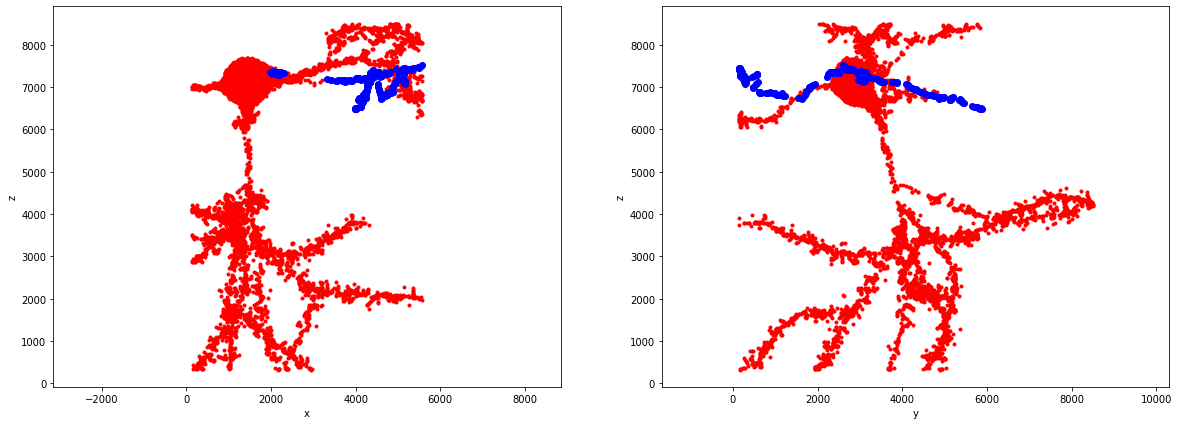

In [31]:
# Plot neuron 1
idx = 1
plt.figure(figsize=(20, 7))
dendrite_centers = seg_positions[:, np.array(dendrite_segments[idx])-1]
axon_centers_a = seg_positions[:, np.array(axon_segments2[idx])-1]
plt.subplot(121)
plt.plot(dendrite_centers[0, :], dendrite_centers[2, :] * 2.49, 'r.')
plt.plot(axon_centers_a[0, :], axon_centers_a[2, :] * 2.49, 'bo')
#plt.plot(axon_centers_b[0, :], axon_centers_b[2, :] * 2.49, 'ko')
plt.xlabel('x')
plt.ylabel('z')
plt.box('off')
plt.axis('equal')
plt.subplot(122)
plt.plot(dendrite_centers[1, :], dendrite_centers[2, :] * 2.49, 'r.')
plt.plot(axon_centers_a[1, :], axon_centers_a[2, :] * 2.49, 'bo')
#plt.plot(axon_centers_b[1, :], axon_centers_b[2, :] * 2.49, 'ko')
plt.xlabel('y')
plt.ylabel('z')
plt.box('off')
plt.axis('equal')

Save it to GCS.

In [113]:
full_map = {**dendrite_map, **axon_map}
print(sum([1 for v in dendrite_map.values() if v == 1]))
print(sum([1 for v in axon_map.values() if v == 1]))

624598
9482
367


In [107]:
fs = gcsfs.GCSFileSystem(project='neuron-jungle', token=credentials)
with fs.open('l4dense/neuron-map-with-axons.pkl', 'wb') as f:
    f.write(pickle.dumps(full_map))

In [108]:
fs = gcsfs.GCSFileSystem(project='neuron-jungle', token=credentials)
with fs.open('l4dense/neuron-map.pkl', 'rb') as f:
    segment_to_neuron = pickle.loads(f.read())

with fs.open('l4dense/neuron-map-with-axons.pkl', 'rb') as f:
    segment_to_neuron_with_axons = pickle.loads(f.read())

In [114]:
print(sum([1 for v in segment_to_neuron.values() if v == 1]))
print(sum([1 for v in segment_to_neuron_with_axons.values() if v == 1]))

9482
9760


In [237]:
id = 2
print(sum(v == id for v in segment_to_neuron.values()))
#len(segment_to_neuron_with_axons)
print(sum(v == id for v in segment_to_neuron_with_axons.values()))

1142
1142


In [120]:
@numba.jit(nopython=True)
def remap(data, the_map):
    b = np.zeros_like(data)
    c = {}
    for i in range(len(data)):
        if data[i] in the_map:
            b[i] = the_map[data[i]]
            c[the_map[data[i]]] = 1
    return b, c

In [130]:
# To repaint: map dendrite ids to neuron id (default to 0)
from scipy.ndimage import morphology

@dask.delayed
def repaint(filename, credentials): 
    print("Repainting")
    
    # Create a typed map for segment_to_neuron
    out_name = f'l4dense/neuron-volume-with-axons-unfilled/{filename}'
    fs = gcsfs.GCSFileSystem(project='neuron-jungle', token=credentials)
    if fs.exists(out_name):
        print("File already exists")
        return 0
    with fs.open('l4dense/neuron-map-with-axons.pkl', 'rb') as f:
        segment_to_neuron = pickle.loads(f.read())

    the_map_typed = Dict.empty(key_type=numba.int32, value_type=numba.uint8)
    for k, v in segment_to_neuron.items():
        the_map_typed[k] = v
    
    neuron_ids = set()
    with fs.open(f'l4dense/segmentation-volume/{filename}', 'rb') as f:    
        cube = h5py.File(f, 'r')
        
        a = np.zeros((1024, 1024, 1024), dtype=np.uint8)
        
        slice_size = 32
        nslices = int(1024 / slice_size)
        
        for j in range(nslices):
            subd = np.array(cube['data'][(slice_size*j):(slice_size*(j+1)), :, :])
            for i in range(nslices):
                r, neuron_id = remap(subd[i, :, :].ravel(), the_map_typed)
                a[i + j*slice_size, :, :] = r.astype(np.uint8).reshape((1024, 1024))
                neuron_ids = neuron_ids.union(set(neuron_id.keys()))
    
    neuron_ids = np.array(list(neuron_ids))
    
    #a = morphology.grey_erosion(morphology.grey_dilation(a, size=5), size=5)
    
    bio = io.BytesIO()
    cube = h5py.File(bio, 'w')
    cube.create_dataset('data', a.shape, compression="gzip", data=a)
    cube.create_dataset('neuron_ids', neuron_ids.shape, data=neuron_ids)
    cube.close()

    data = bio.getvalue()
    with fs.open(out_name, 'wb') as f:
        f.write(data)
    return len(data)

In [131]:
# x5y8z3 are the largest ids
bytes_total = 0
for i in range(6):
    for j in range(9):
        for k in range(4):
            print(i, j, k)
            bytes_total += repaint(f"x{i}y{j}z{k}.hdf5", credentials)
bytes_total.compute()

0 0 0
0 0 1
0 0 2
0 0 3
0 1 0
0 1 1
0 1 2
0 1 3
0 2 0
0 2 1
0 2 2
0 2 3
0 3 0
0 3 1
0 3 2
0 3 3
0 4 0
0 4 1
0 4 2
0 4 3
0 5 0
0 5 1
0 5 2
0 5 3
0 6 0
0 6 1
0 6 2
0 6 3
0 7 0
0 7 1
0 7 2
0 7 3
0 8 0
0 8 1
0 8 2
0 8 3
1 0 0
1 0 1
1 0 2
1 0 3
1 1 0
1 1 1
1 1 2
1 1 3
1 2 0
1 2 1
1 2 2
1 2 3
1 3 0
1 3 1
1 3 2
1 3 3
1 4 0
1 4 1
1 4 2
1 4 3
1 5 0
1 5 1
1 5 2
1 5 3
1 6 0
1 6 1
1 6 2
1 6 3
1 7 0
1 7 1
1 7 2
1 7 3
1 8 0
1 8 1
1 8 2
1 8 3
2 0 0
2 0 1
2 0 2
2 0 3
2 1 0
2 1 1
2 1 2
2 1 3
2 2 0
2 2 1
2 2 2
2 2 3
2 3 0
2 3 1
2 3 2
2 3 3
2 4 0
2 4 1
2 4 2
2 4 3
2 5 0
2 5 1
2 5 2
2 5 3
2 6 0
2 6 1
2 6 2
2 6 3
2 7 0
2 7 1
2 7 2
2 7 3
2 8 0
2 8 1
2 8 2
2 8 3
3 0 0
3 0 1
3 0 2
3 0 3
3 1 0
3 1 1
3 1 2
3 1 3
3 2 0
3 2 1
3 2 2
3 2 3
3 3 0
3 3 1
3 3 2
3 3 3
3 4 0
3 4 1
3 4 2
3 4 3
3 5 0
3 5 1
3 5 2
3 5 3
3 6 0
3 6 1
3 6 2
3 6 3
3 7 0
3 7 1
3 7 2
3 7 3
3 8 0
3 8 1
3 8 2
3 8 3
4 0 0
4 0 1
4 0 2
4 0 3
4 1 0
4 1 1
4 1 2
4 1 3
4 2 0
4 2 1
4 2 2
4 2 3
4 3 0
4 3 1
4 3 2
4 3 3
4 4 0
4 4 1
4 4 2
4 4 3
4 5 0
4 5 1
4 5 

distributed.scheduler - INFO - Register tcp://10.36.72.2:35501
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.36.72.2:35501
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Retire worker names (32, 33, 27, 28)
distributed.deploy.adaptive - INFO - Retiring workers [32, 33, 27, 28]
distributed.scheduler - INFO - Remove worker tcp://10.36.72.2:35501
distributed.core - INFO - Removing comms to tcp://10.36.72.2:35501
distributed.scheduler - INFO - Lost all workers
distributed.scheduler - INFO - Retire worker names (29,)
distributed.deploy.adaptive - INFO - Retiring workers [29]
distributed.scheduler - INFO - Retire worker names (30,)
distributed.deploy.adaptive - INFO - Retiring workers [30]
distributed.scheduler - INFO - Register tcp://10.36.72.4:39077
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.36.72.4:39077
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - R

4673480

distributed.scheduler - INFO - Retire worker names (31,)
distributed.deploy.adaptive - INFO - Retiring workers [31]
distributed.scheduler - INFO - Remove worker tcp://10.36.72.4:39077
distributed.core - INFO - Removing comms to tcp://10.36.72.4:39077
distributed.scheduler - INFO - Lost all workers


In [136]:
# x5y8z3 are the largest ids
# To repaint: map dendrite ids to neuron id (default to 0)
from scipy.ndimage import morphology

@dask.delayed
def infill(filename, credentials): 
    print("Infill between segments using morphological operations")
    out_name = f'l4dense/neuron-volume-with-axons-filled/{filename}'
    fs = gcsfs.GCSFileSystem(project='neuron-jungle', token=credentials)
    if fs.exists(out_name):
        print("Out file already exists")
        return 0
    
    with fs.open(f'l4dense/neuron-volume-with-axons-unfilled/{filename}', 'rb') as f:
        cube = h5py.File(f, 'r')
        data = np.array(cube['data'])
        neuron_ids = np.array(cube['neuron_ids'])
    
    data = morphology.grey_dilation(data, size=5)
    data = morphology.grey_erosion(data, size=5)
    
    bio = io.BytesIO()
    cube = h5py.File(bio, 'w')
    cube.create_dataset('data', data.shape, compression="gzip", data=data)
    cube.create_dataset('neuron_ids', neuron_ids.shape, data=neuron_ids)
    cube.close()

    data = bio.getvalue()
    with fs.open(out_name, 'wb') as f:
        f.write(data)
    return len(data)

In [137]:
fs = gcsfs.GCSFileSystem(project='neuron-jungle', token=credentials)

bytes_total = 0
for i in range(6):
    for j in range(9):
        for k in range(4):
            print(i, j, k)
            bytes_total += infill(f"x{i}y{j}z{k}.hdf5", credentials)
            #filename = f"x{i}y{j}z{k}.hdf5"
            #out_name = f'l4dense/neuron-volume-with-axons-filled/{filename}'
            #with fs.open(f'l4dense/neuron-volume-with-axons-unfilled/{filename}', 'rb') as f:
            #    cube = h5py.File(f, 'r')
            #    neuron_ids = np.array(cube['neuron_ids'])
            
bytes_total.compute()

0 0 0
0 0 1
0 0 2
0 0 3
0 1 0
0 1 1
0 1 2
0 1 3
0 2 0
0 2 1
0 2 2
0 2 3
0 3 0
0 3 1
0 3 2
0 3 3
0 4 0
0 4 1
0 4 2
0 4 3
0 5 0
0 5 1
0 5 2
0 5 3
0 6 0
0 6 1
0 6 2
0 6 3
0 7 0
0 7 1
0 7 2
0 7 3
0 8 0
0 8 1
0 8 2
0 8 3
1 0 0
1 0 1
1 0 2
1 0 3
1 1 0
1 1 1
1 1 2
1 1 3
1 2 0
1 2 1
1 2 2
1 2 3
1 3 0
1 3 1
1 3 2
1 3 3
1 4 0
1 4 1
1 4 2
1 4 3
1 5 0
1 5 1
1 5 2
1 5 3
1 6 0
1 6 1
1 6 2
1 6 3
1 7 0
1 7 1
1 7 2
1 7 3
1 8 0
1 8 1
1 8 2
1 8 3
2 0 0
2 0 1
2 0 2
2 0 3
2 1 0
2 1 1
2 1 2
2 1 3
2 2 0
2 2 1
2 2 2
2 2 3
2 3 0
2 3 1
2 3 2
2 3 3
2 4 0
2 4 1
2 4 2
2 4 3
2 5 0
2 5 1
2 5 2
2 5 3
2 6 0
2 6 1
2 6 2
2 6 3
2 7 0
2 7 1
2 7 2
2 7 3
2 8 0
2 8 1
2 8 2
2 8 3
3 0 0
3 0 1
3 0 2
3 0 3
3 1 0
3 1 1
3 1 2
3 1 3
3 2 0
3 2 1
3 2 2
3 2 3
3 3 0
3 3 1
3 3 2
3 3 3
3 4 0
3 4 1
3 4 2
3 4 3
3 5 0
3 5 1
3 5 2
3 5 3
3 6 0
3 6 1
3 6 2
3 6 3
3 7 0
3 7 1
3 7 2
3 7 3
3 8 0
3 8 1
3 8 2
3 8 3
4 0 0
4 0 1
4 0 2
4 0 3
4 1 0
4 1 1
4 1 2
4 1 3
4 2 0
4 2 1
4 2 2
4 2 3
4 3 0
4 3 1
4 3 2
4 3 3
4 4 0
4 4 1
4 4 2
4 4 3
4 5 0
4 5 1
4 5 

distributed.scheduler - INFO - Register tcp://10.36.76.4:34629
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.36.76.4:34629
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Retire worker names (42,)
distributed.deploy.adaptive - INFO - Retiring workers [42]
distributed.scheduler - INFO - Remove worker tcp://10.36.76.4:34629
distributed.core - INFO - Removing comms to tcp://10.36.76.4:34629
distributed.scheduler - INFO - Lost all workers
distributed.scheduler - INFO - Retire worker names (43, 44)
distributed.deploy.adaptive - INFO - Retiring workers [43, 44]
distributed.scheduler - INFO - Register tcp://10.36.75.4:45651
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.36.75.4:45651
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Retire worker names (48,)
distributed.deploy.adaptive - INFO - Retiring workers [48]
distributed.scheduler - INFO - Retire worker nam

KilledWorker: ('infill-59b82cc4-8ddc-4c51-ab4c-2339faea3222', <Worker 'tcp://10.36.72.8:34829', memory: 0, processing: 24>)

distributed.scheduler - INFO - Retire worker names (50, 51, 52, 53, 54, 55)
distributed.deploy.adaptive - INFO - Retiring workers [50, 51, 52, 53, 54, 55]
distributed.scheduler - INFO - Remove worker tcp://10.36.78.4:46729
distributed.core - INFO - Removing comms to tcp://10.36.78.4:46729
distributed.scheduler - INFO - Remove worker tcp://10.36.76.6:32915
distributed.core - INFO - Removing comms to tcp://10.36.76.6:32915
distributed.scheduler - INFO - Remove worker tcp://10.36.74.5:40951
distributed.core - INFO - Removing comms to tcp://10.36.74.5:40951
distributed.scheduler - INFO - Remove worker tcp://10.36.75.5:33557
distributed.core - INFO - Removing comms to tcp://10.36.75.5:33557
distributed.scheduler - INFO - Remove worker tcp://10.36.73.5:33121
distributed.core - INFO - Removing comms to tcp://10.36.73.5:33121
distributed.scheduler - INFO - Lost all workers


We're done!